Neuroimaging non-cartesian reconstruction
=========================================
Author: Chaithya G R
In this tutorial we will reconstruct an MRI image from cartesian kspace
measurements.
Import neuroimaging data
------------------------
We use the toy datasets available in pysap, more specifically a 2D parallel MRI
brain slice on 32 channels and the acquisition cartesian scheme.

In [2]:
from mri.operators import FFT, WaveletN
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors import SelfCalibrationReconstructor
import pysap
from pysap.data import get_sample_data

# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
import matplotlib.pyplot as plt

Loading input data and Cartesian Mask

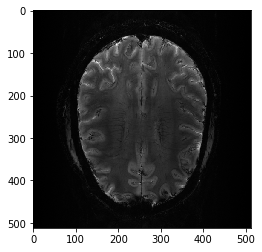

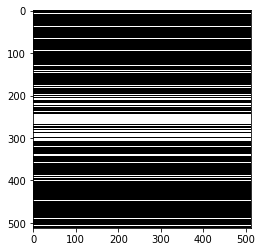

In [3]:
cartesian_ref_image = get_sample_data('2d-pmri')
image = pysap.Image(data=np.sqrt(np.sum(cartesian_ref_image.data**2, axis=0)))
# Obtain MRI non-cartesian mask
mask = get_sample_data("cartesian-mri-mask")
kspace_loc = convert_mask_to_locations(mask.data)
plt.figure()
plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(mask, cmap='gray')
plt.show()

Generate the kspace
-------------------

From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a cartesian acquisition mask
We then reconstruct the zero order solution as a baseline

In [4]:
# Get the locations of the kspace samples and the associated observations
fourier_op = FFT(samples=kspace_loc, shape=image.shape,
                 n_coils=cartesian_ref_image.shape[0])
kspace_obs = fourier_op.op(cartesian_ref_image)

/home/chaithyagr/Codes/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


Zero Filled reconstruction

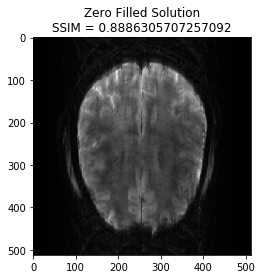

In [5]:
zero_filled = fourier_op.adj_op(kspace_obs)
image_rec0 = pysap.Image(data=np.sqrt(np.sum(np.abs(zero_filled)**2, axis=0)))
# image_rec0.show()
base_ssim = ssim(image_rec0, image)
plt.imshow(np.abs(image_rec0), cmap='gray')
# Calculate SSIM
base_ssim = ssim(image_rec0, image)
plt.title('Zero Filled Solution\nSSIM = ' + str(base_ssim))
plt.show()

 
Setup the operators for reconstruction
--------------------------------------

Linear Operator : Symlet 8 with 4 scales

In [6]:
linear_op = WaveletN(
    wavelet_name='sym8',
    nb_scale=4,
)

Regularizer : L1 Norm with lambda = 15e-9

In [7]:
regularizer_op = SparseThreshold(Identity(), 15e-9, thresh_type="soft")

Setup Reconstructor. We choose Kspace between -0.01 to 0.01 for obtaining the Channel Senistivity maps

In [9]:
reconstructor = SelfCalibrationReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    kspace_portion=0.01,
    verbose=1,
)

FISTA optimization
------------------
We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

In [10]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=10,
)
image_rec = pysap.Image(data=x_final)
recon_ssim = ssim(image_rec, image)

/home/chaithyagr/Codes/pysap-mri/mri/reconstructors/utils/extract_sensitivity_maps.py:60: UserWarning: Data Values seems to have dimension 3 (>2). Using isFFT for now.
  ' (>2). Using isFFT for now.')
100% (10 of 10) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


Lipschitz constant is 1.0985145846684372
The lipschitz constraint is satisfied
 - mu:  1.5e-08
 - lipschitz constant:  1.0985145846684372
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7f6f4a999eb8> - 4
 - max iterations:  10
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...
 - final iteration number:  10
 - final log10 cost value:  -9.885567448907405
 - converged:  False
Done.
Execution time:  22.48468799999999  seconds
----------------------------------------


Estimated Sensitivity map Profiles:

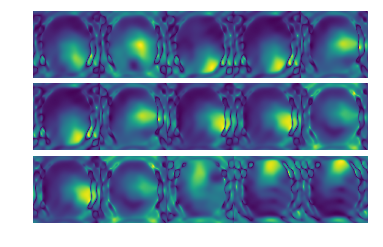

In [19]:
h=3;w=5;
f, axs = plt.subplots(h,w)
for i in range(h):
    for j in range(w):
        axs[i, j].imshow(np.abs(reconstructor.extra_grad_args['Smaps'][3 * i + j]))
        axs[i, j].axis('off')
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

Reconstructed Result

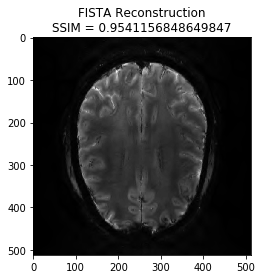

In [20]:
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('FISTA Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()